In [1]:
# Misc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
import gc
import warnings

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder
from imblearn.under_sampling import RandomUnderSampler

# # Import libraries for Hypertuning
import optuna

# # Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

In [2]:
# Seaborn
rc = {
    "axes.facecolor": "#FAEEE9",
    "figure.facecolor": "#FAEEE9",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)

# Useful line of code to set the display option so we could see all the columns in pd dataframe
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Functions
def print_sl():
    print("=" * 50)
    print()

def show_na(df, column):
    sns.countplot(x='outcome', data=df[df[column].isnull()])
    plt.show() 

# Load Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

train_orig = pd.read_csv('horse.csv')

train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

print('Data Loaded Succesfully!')
print_sl()

print(f'train shape: {train.shape}')
print(f'are there any null values in train: {train.isnull().any().any()}\n')

print(f'test shape: {test.shape}')
print(f'are there any null values in test: {test.isnull().any().any()}\n')

print(f'train_orig shape: {train_orig.shape}')
print(f'are there any null values in test: {train_orig.isnull().any().any()}\n')

categorical_cols = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time',
                   'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
                   'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']

num_cols = ['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein',
           'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']

target = 'outcome'

train.head()

Data Loaded Succesfully!

train shape: (1235, 28)
are there any null values in train: False

test shape: (824, 27)
are there any null values in test: False

train_orig shape: (299, 28)
are there any null values in test: True



,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,None,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


# EDA

## Target Distribution¶

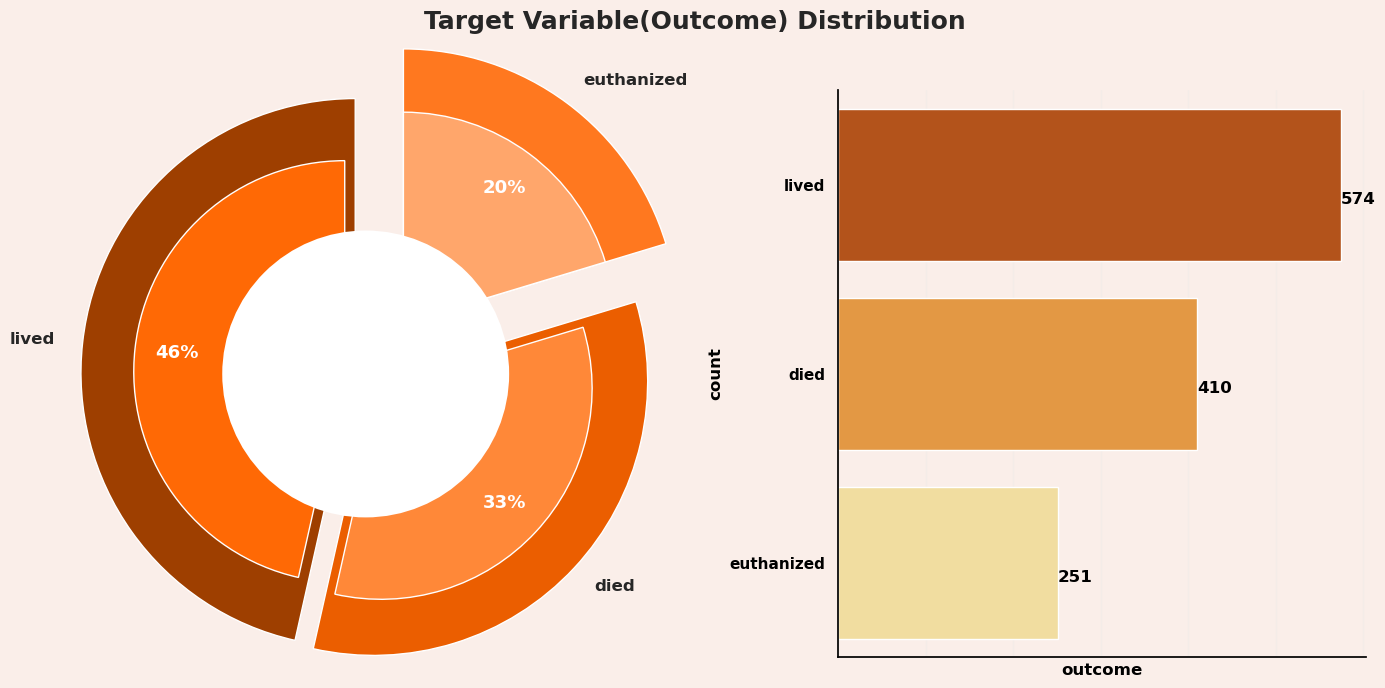

In [4]:
# https://www.kaggle.com/code/kimtaehun/eda-and-baseline-with-multiple-models
def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
    # Set background color
    
    f, ax = plt.subplots(1, 2, figsize=(14, 7))
    plt.subplots_adjust(wspace=0.2)

    s1 = df[col].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = ['#9E3F00', '#eb5e00', '#ff781f']
    inner_colors = ['#ff6905', '#ff8838', '#ffa66b']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90, frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size': 13, 
        'weight': 'bold', 
        'color': 'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = s1.index.tolist()
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette='YlOrBr_r', orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i+0.1, str(v), color='black', fontweight='bold', fontsize=12)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col, fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name}', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_count(train, 'outcome', 'Target Variable(Outcome) Distribution')

## Categorical Variables

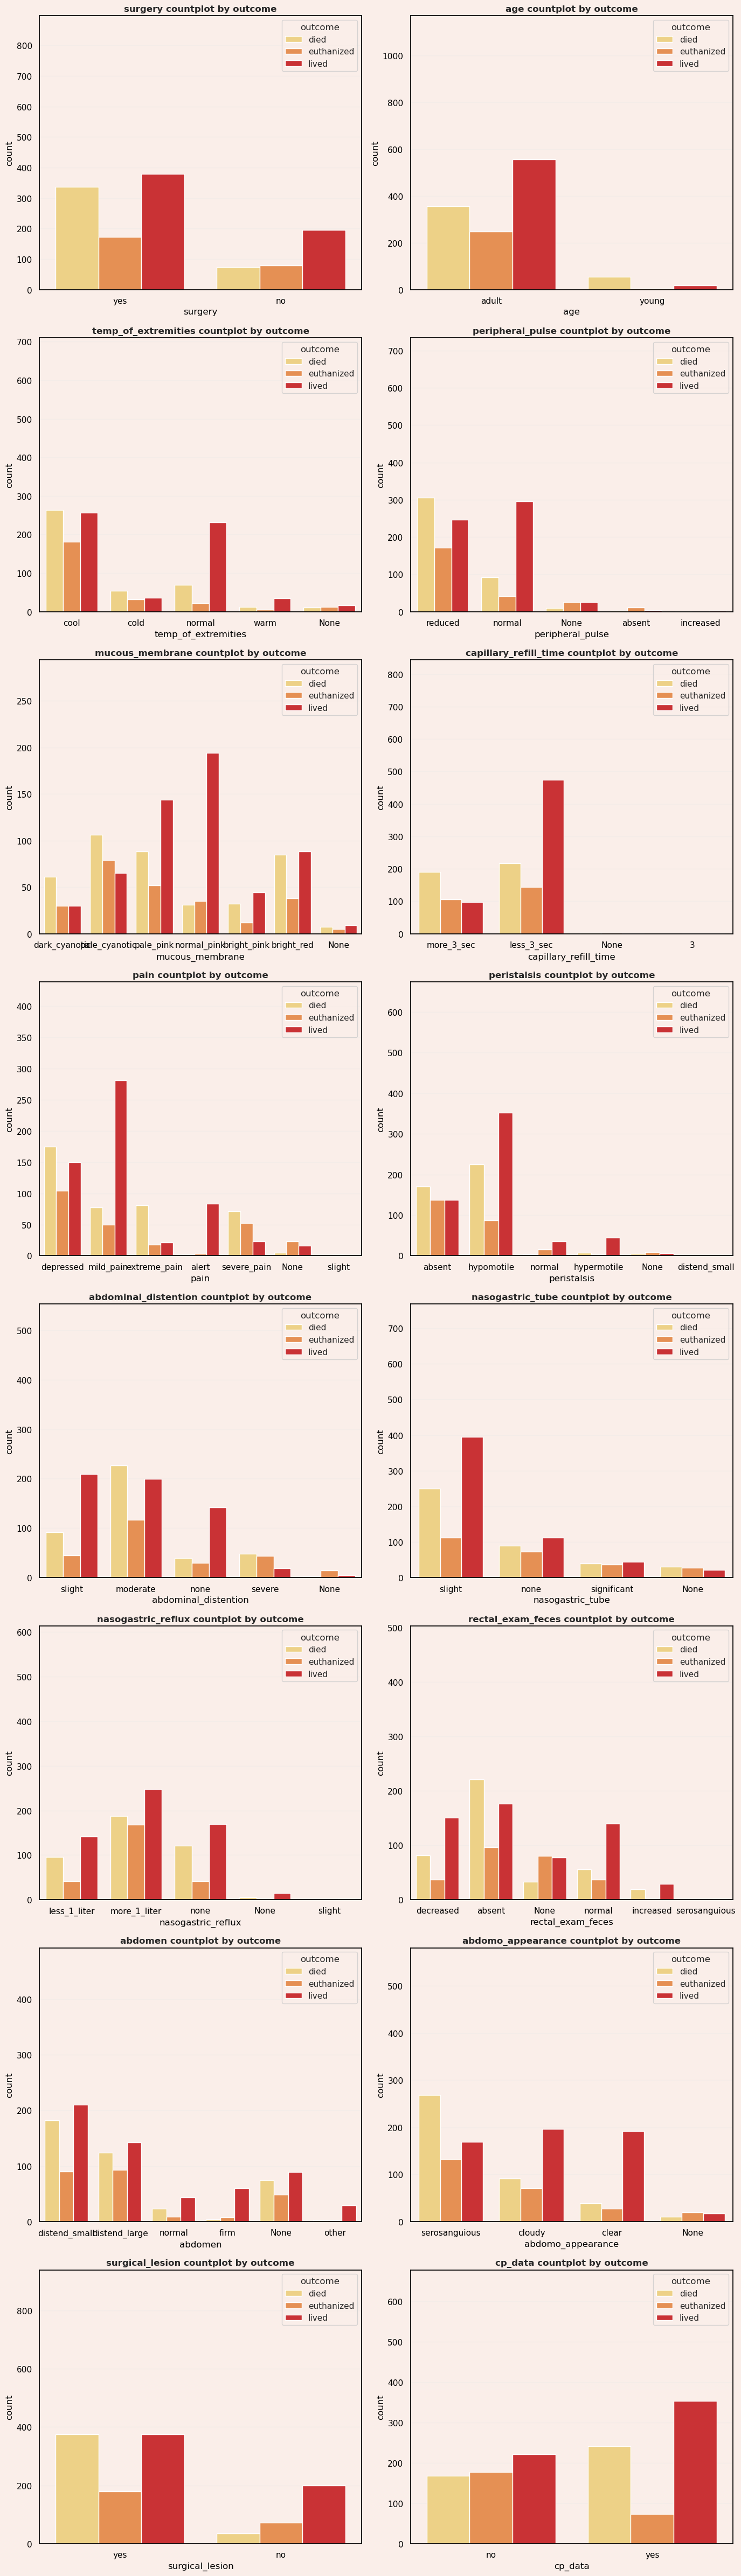

In [5]:
plt.figure(figsize=(14, len(categorical_cols)*3))

for i, col in enumerate(categorical_cols):
    
    plt.subplot(len(categorical_cols)//2 + len(categorical_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue="outcome", data=train, palette='YlOrRd')
    plt.title(f"{col} countplot by outcome", fontweight = 'bold')
    plt.ylim(0, train[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

## Numerical Variables

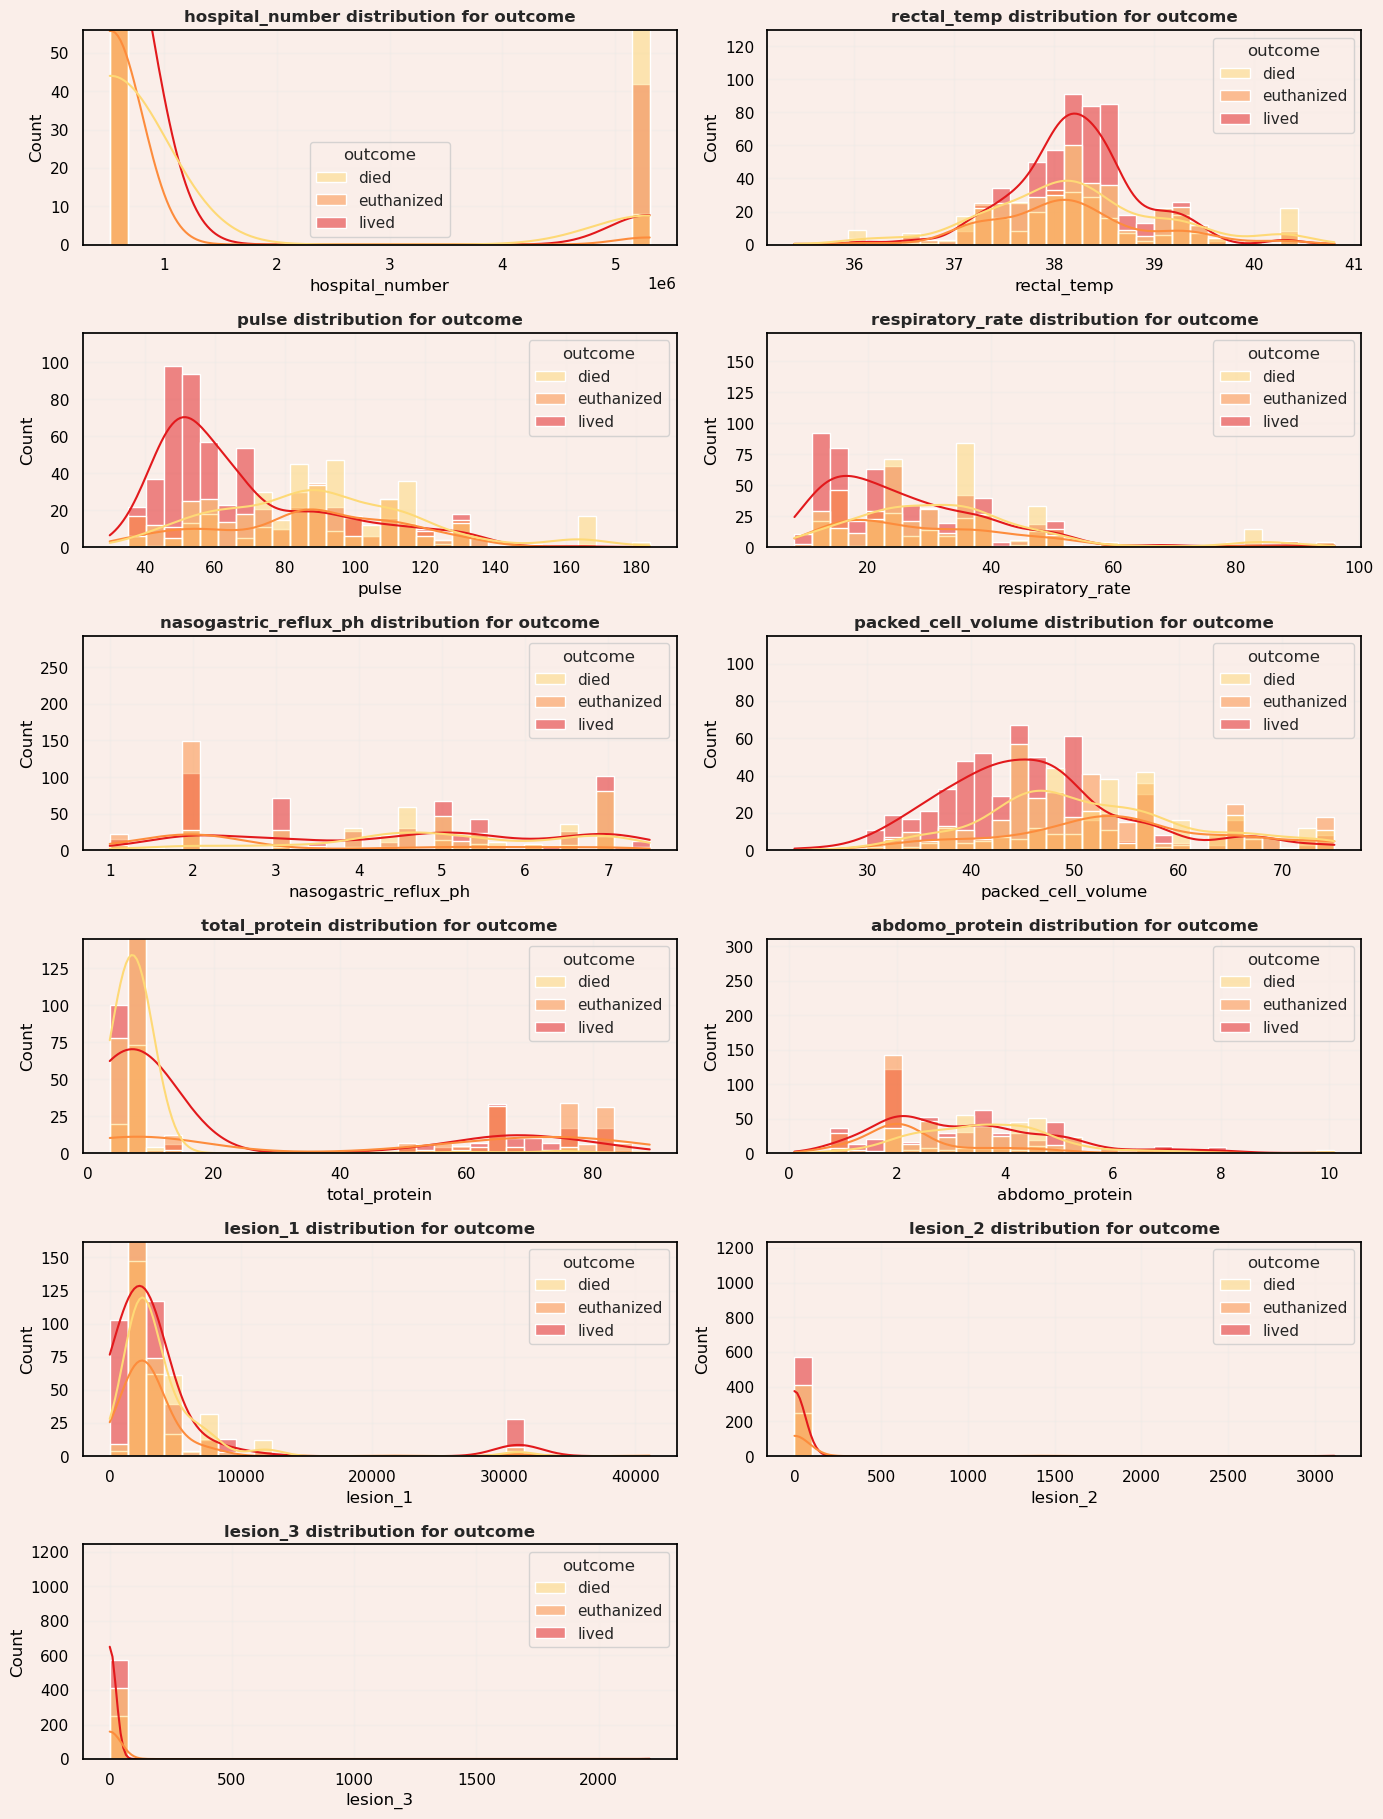

In [6]:
plt.figure(figsize=(14, len(num_cols) * 3))

for i, col in enumerate(num_cols):
    # Plotting for outcome
    plt.subplot(len(num_cols), 2, i+1)
    sns.histplot(x=col, hue="outcome", data=train, bins=30, kde=True, palette='YlOrRd')
    plt.title(f"{col} distribution for outcome", fontweight="bold")
    plt.ylim(0, train[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

# Scatter Matrix

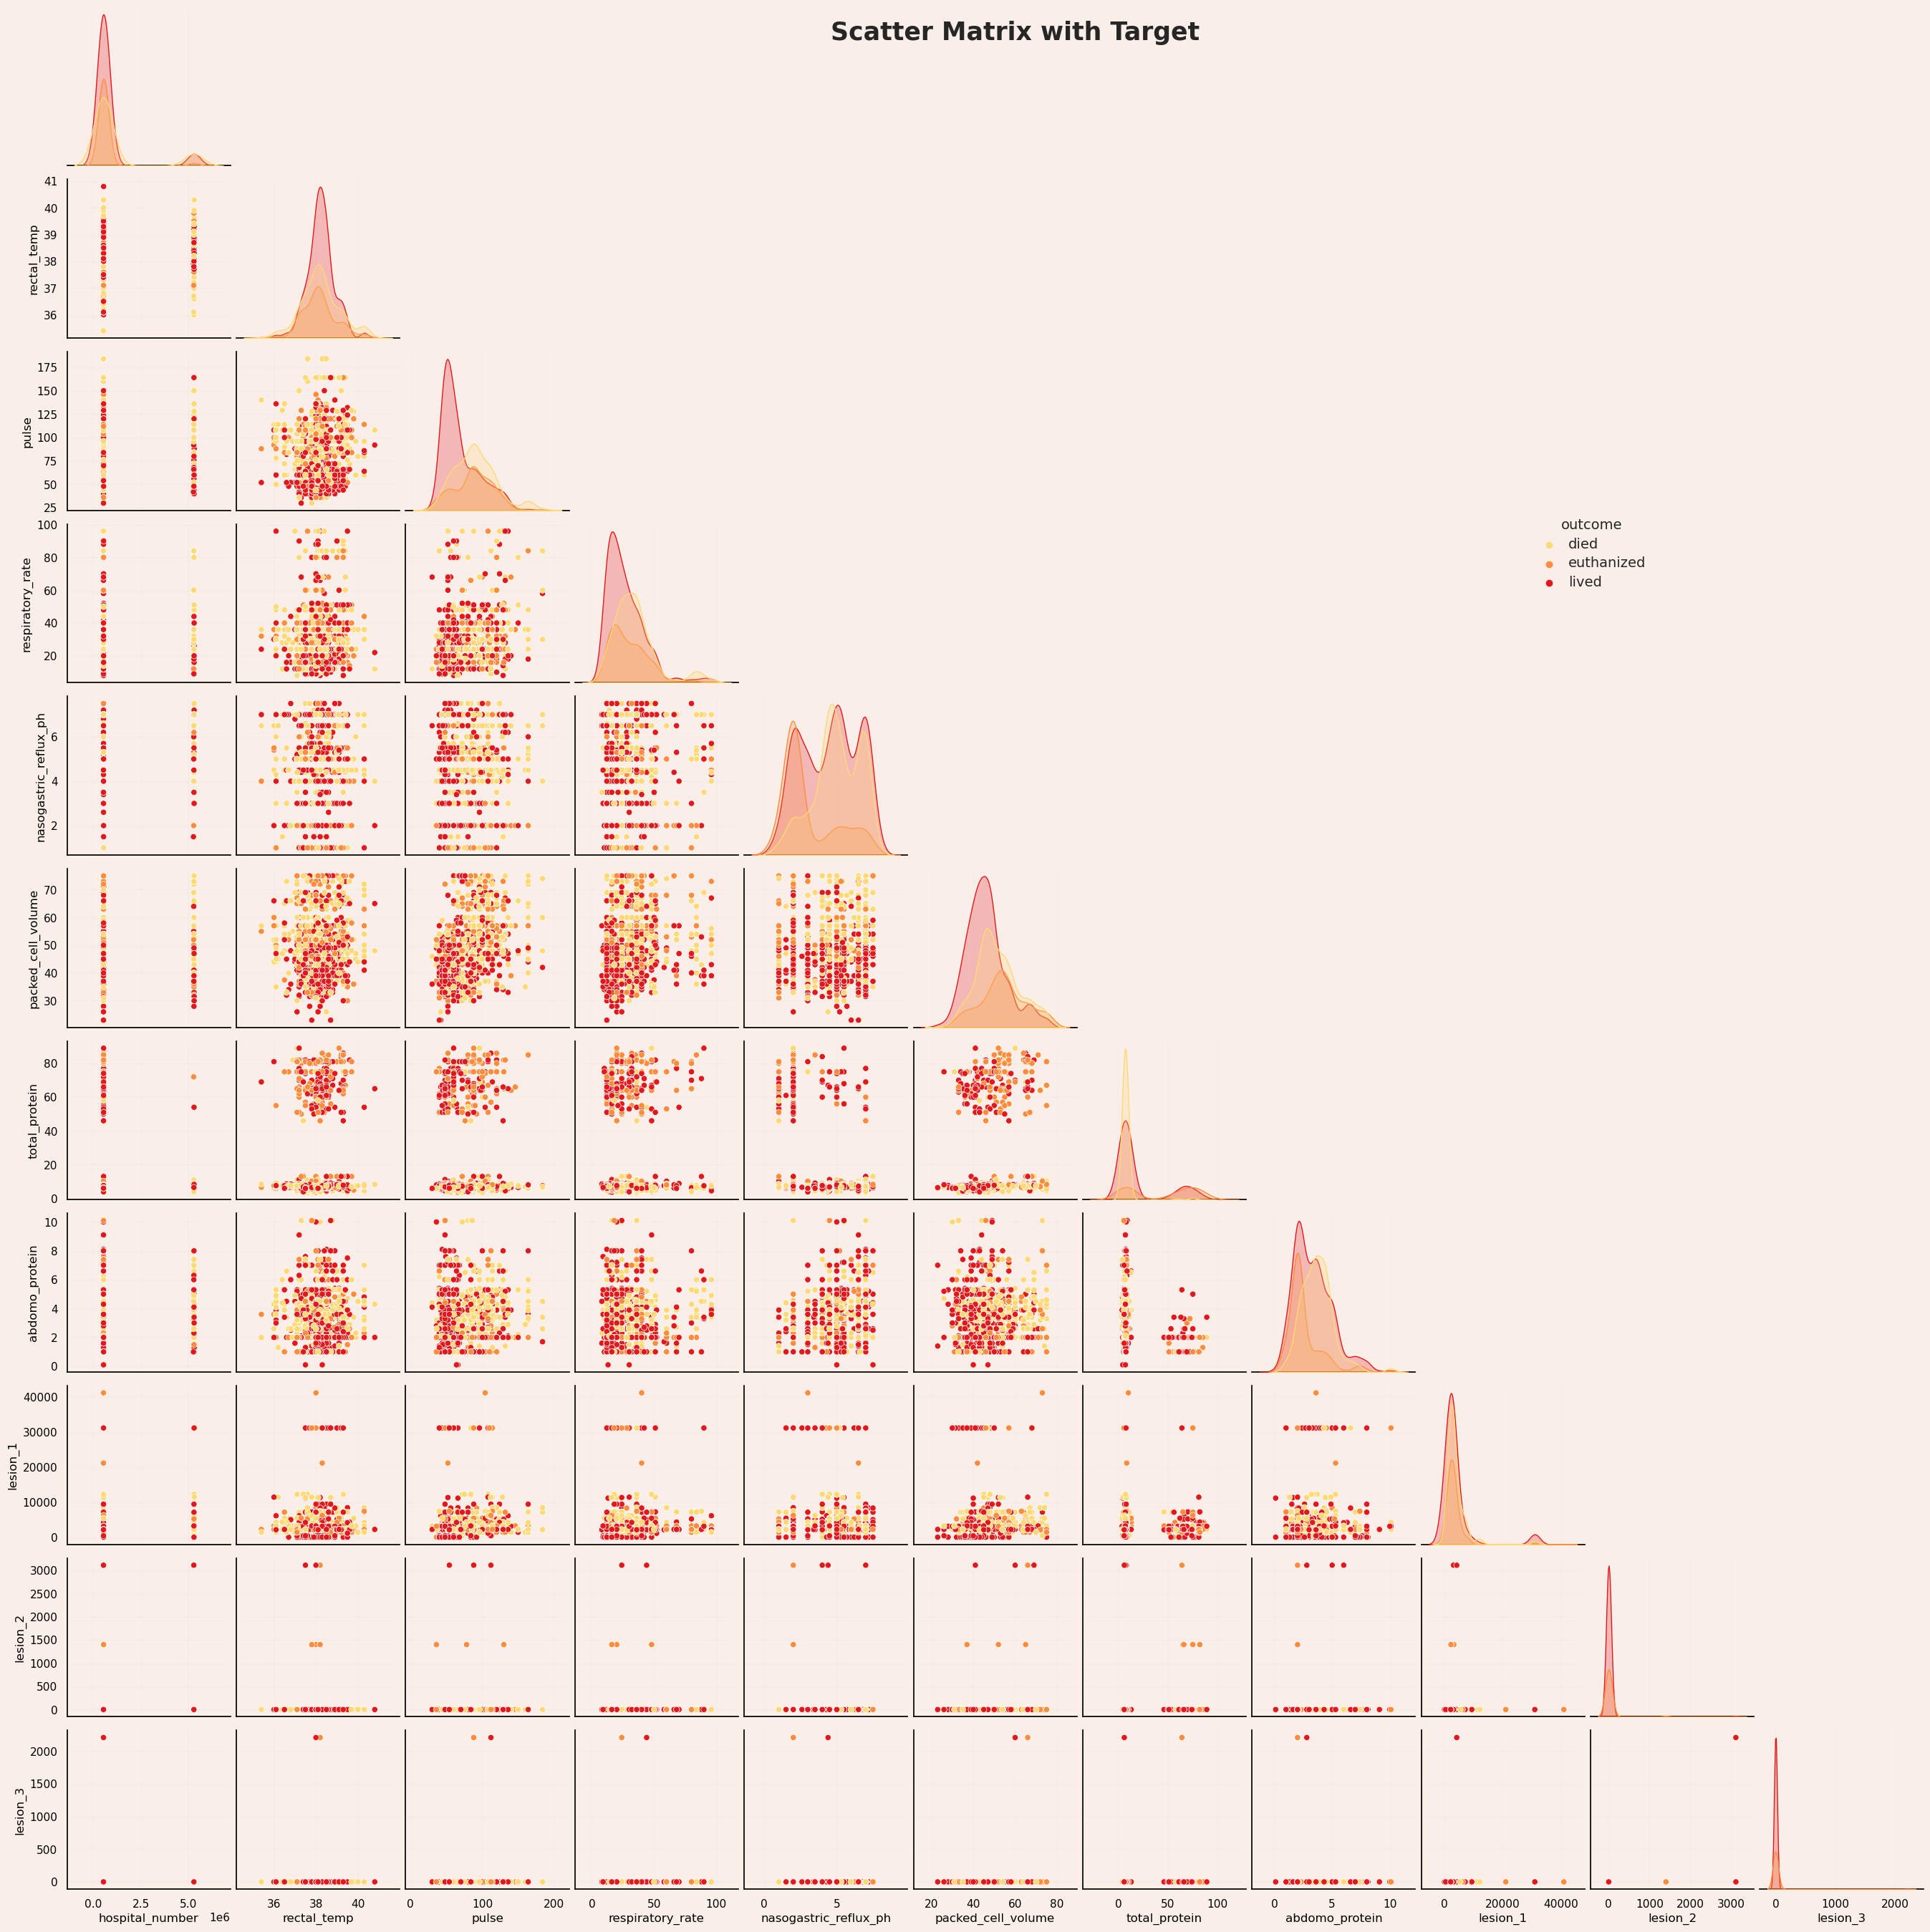

In [7]:
# https://www.kaggle.com/code/yaaangzhou/playground-s3-e22-eda-modeling/notebook
def plot_pair(df_train,num_var,target,plotname):
    '''
    Funtion to make a pairplot:
    df_train: total data
    num_var: a list of numeric variable
    target: target variable
    '''
    g = sns.pairplot(data=df_train, x_vars=num_var, y_vars=num_var, hue=target, corner=True,  palette='YlOrRd')
    g._legend.set_bbox_to_anchor((0.8, 0.7))
    g._legend.set_title(target)
    g._legend.loc = 'upper left'
    g._legend.get_title().set_fontsize(14)
    for item in g._legend.get_texts():
        item.set_fontsize(14)

    plt.suptitle(plotname, ha='center', fontweight='bold', fontsize=25, y=0.98)
    plt.show()

plot_pair(train, num_cols, target, plotname = 'Scatter Matrix with Target')

## Correlation Heatmap

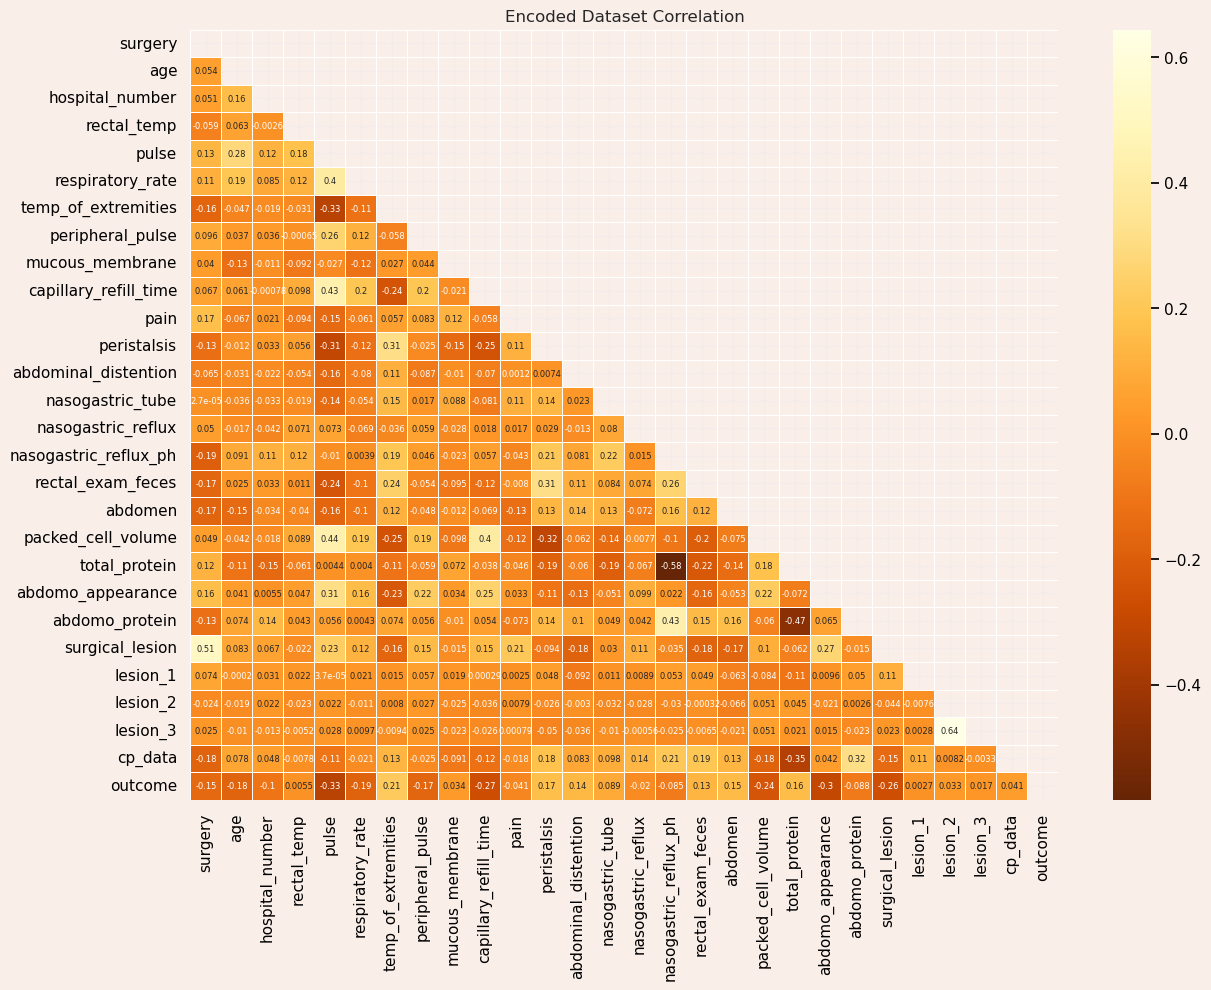

In [8]:
# Create a copy of the dataframe
df_encoded = train.copy()

# Assuming these are your categorical variables, including 'outcome'
categorical_vars = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 
                    'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 
                    'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 
                    'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 
                    'cp_data', 'outcome']

# Label encode categorical columns
label_encoders = {}
for column in categorical_vars:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(train[column])
    label_encoders[column] = le

def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str = 'Train correlation') -> None:
    excluded_columns = ['id']
    columns_without_excluded = [col for col in df.columns if col not in excluded_columns]
    corr = df[columns_without_excluded].corr()
    
    fig, axes = plt.subplots(figsize=(14, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True, annot_kws={"size": 6})
    plt.title(title_name)
    plt.show()

# Plot correlation heatmap for encoded dataframe
plot_correlation_heatmap(df_encoded, 'Encoded Dataset Correlation')

# Data Cleaning

In [9]:
def preprocessing(df, le_cols, ohe_cols):
    
    le = LabelEncoder()
    
    for col in le_cols:
        df[col] = le.fit_transform(df[col])
        
    df = pd.get_dummies(df, columns = ohe_cols)
    
    df["pain"] = df["pain"].replace('slight', 'moderate')
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')
        
    df["temp_of_extremities"] = df["temp_of_extremities"].fillna("normal").map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3})
    df["peripheral_pulse"] = df["peripheral_pulse"].fillna("normal").map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3})
    df["capillary_refill_time"] = df["capillary_refill_time"].fillna("3").map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2})
    df["pain"] = df["pain"].fillna("depressed").map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5})
    df["peristalsis"] = df["peristalsis"].fillna("hypomotile").map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3})
    df["abdominal_distention"] = df["abdominal_distention"].fillna("none").map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3})
    df["nasogastric_tube"] = df["nasogastric_tube"].fillna("none").map({'none': 0, 'slight': 1, 'significant': 2})
    df["nasogastric_reflux"] = df["nasogastric_reflux"].fillna("none").map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2})
    df["rectal_exam_feces"] = df["rectal_exam_feces"].fillna("absent").map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3})
    df["abdomen"] = df["abdomen"].fillna("distend_small").map({'normal': 0, 'other': 1, 'firm': 2,'distend_small': 3, 'distend_large': 4})
    df["abdomo_appearance"] = df["abdomo_appearance"].fillna("serosanguious").map({'clear': 0, 'cloudy': 1, 'serosanguious': 2})
    
    df.drop('lesion_3',axis=1,inplace=True)

    return df

def features_engineering(df):
    df['lesion_2'] = df['lesion_2'].apply(lambda x:1 if x>0 else 0)
    data_preprocessed = df.copy()
     
    data_preprocessed["abs_rectal_temp"] = (data_preprocessed["rectal_temp"] - 37.8).abs()
    data_preprocessed.drop(columns=["rectal_temp"])
    
    return data_preprocessed

In [10]:
le_cols = ["surgery", "age", "surgical_lesion", "cp_data"]
ohe_cols = ["mucous_membrane"]

train = preprocessing(train, le_cols, ohe_cols)
test = preprocessing(test, le_cols, ohe_cols)
train_orig = preprocessing(train_orig, le_cols, ohe_cols)

#train = encode(train, categorical_cols)
#test = encode(test, categorical_cols)
#train_orig = encode(train_orig, categorical_cols)

total = pd.concat([train, train_orig], ignore_index=True)
total.drop_duplicates(inplace=True)

total = features_engineering(total)
test = features_engineering(test)


print(f'train shape: {train.shape}')
print(f'are there any null values in train: {train.isnull().any().any()}\n')

print(f'test shape: {test.shape}')
print(f'are there any null values in test: {test.isnull().any().any()}\n')

print(f'total shape: {total.shape}')
print(f'are there any null values in total: {total.isnull().any().any()}\n')

total.head()

train shape: (1235, 33)
are there any null values in train: True

test shape: (824, 33)
are there any null values in test: True

total shape: (1534, 34)
are there any null values in total: True



,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,cp_data,outcome,mucous_membrane_None,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,abs_rectal_temp
0,1,0,530001,38.1,132.0,24.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,6.5,1.0,3.0,57.0,8.5,2.0,3.4,1,2209,0,0,died,0.0,0,0,1,0,0,0,0.3
1,1,0,533836,37.5,88.0,12.0,1.0,2.0,2.0,3.0,3.0,2.0,0.0,2.0,2.0,0.0,3.0,33.0,64.0,2.0,2.0,1,2208,0,0,euthanized,0.0,0,0,0,0,1,0,0.3
2,1,0,529812,38.3,120.0,28.0,1.0,1.0,0.0,5.0,2.0,2.0,1.0,1.0,3.5,NaN,4.0,37.0,6.4,2.0,3.4,1,5124,0,0,lived,0.0,0,0,0,0,0,1,0.5
3,1,0,5262541,37.1,72.0,30.0,0.0,1.0,2.0,3.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,53.0,7.0,1.0,3.9,1,2208,0,1,lived,0.0,0,0,0,0,0,1,0.7
4,0,0,5299629,38.0,52.0,48.0,2.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,7.0,2.0,0.0,47.0,7.3,1.0,2.6,0,0,0,1,lived,0.0,0,0,0,1,0,0,0.2


In [11]:
num_cols

['hospital_number',
 'rectal_temp',
 'pulse',
 'respiratory_rate',
 'nasogastric_reflux_ph',
 'packed_cell_volume',
 'total_protein',
 'abdomo_protein',
 'lesion_1',
 'lesion_2',
 'lesion_3']

In [12]:
num_cols.remove('lesion_3')
num_cols.append('abs_rectal_temp')

# Initialize the KNNImputer with the desired number of neighbors
imputer = KNNImputer(n_neighbors=12) # 10 is good 

# Perform KNN imputation
df_train_imputed = pd.DataFrame(imputer.fit_transform(total[num_cols]), columns=num_cols)
df_test_imputed = pd.DataFrame(imputer.transform(test[num_cols]), columns=num_cols)

# Check if there are still missing values in the train and test data sets
df_train_null = df_train_imputed[df_train_imputed.isnull().any(axis=1)]
df_test_null = df_test_imputed[df_test_imputed.isnull().any(axis=1)]

# Display the rows with null values
print('No. of records with missing value in Train data set after Imputation : {}'.format(df_train_null.shape[0]))
print('No. of records with missing value in Test data set after Imputation : {}'.format(df_test_null.shape[0]))

print_sl()

# Replace the imputed columns in the train data sets
total_2 = total.drop(num_cols, axis=1).reset_index()
total_2 = pd.concat([total_2, df_train_imputed], axis=1)

# Replace the imputed columns in the test data sets
test_2 = test.drop(num_cols, axis=1).reset_index()
test_2 = pd.concat([test_2, df_test_imputed], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Total data set : {}'.format(total_2.shape))
print('Shape of the Test data set : {}'.format(test_2.shape))

total_2.head(5)

No. of records with missing value in Train data set after Imputation : 0
No. of records with missing value in Test data set after Imputation : 0

Shape of the Total data set : (1534, 35)
Shape of the Test data set : (824, 34)


,index,surgery,age,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data,outcome,mucous_membrane_None,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,abs_rectal_temp
0,0,1,0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,1.0,3.0,2.0,1,0,died,0.0,0,0,1,0,0,0,530001.0,38.1,132.0,24.0,6.5,57.0,8.5,3.4,2209.0,0.0,0.3
1,1,1,0,1.0,2.0,2.0,3.0,3.0,2.0,0.0,2.0,0.0,3.0,2.0,1,0,euthanized,0.0,0,0,0,0,1,0,533836.0,37.5,88.0,12.0,2.0,33.0,64.0,2.0,2208.0,0.0,0.3
2,2,1,0,1.0,1.0,0.0,5.0,2.0,2.0,1.0,1.0,NaN,4.0,2.0,1,0,lived,0.0,0,0,0,0,0,1,529812.0,38.3,120.0,28.0,3.5,37.0,6.4,3.4,5124.0,0.0,0.5
3,3,1,0,0.0,1.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,3.0,1.0,1,1,lived,0.0,0,0,0,0,0,1,5262541.0,37.1,72.0,30.0,2.0,53.0,7.0,3.9,2208.0,0.0,0.7
4,4,0,0,2.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0,0,1,lived,0.0,0,0,0,1,0,0,5299629.0,38.0,52.0,48.0,7.0,47.0,7.3,2.6,0.0,0.0,0.2


# Model Building

In [13]:
X_train = total_2.drop(columns=[target])
y_train = total_2[target].map({'died':0,'euthanized':1,'lived':2})
X_test = test_2

print(f'X_train shape: {X_train.shape}')

print(f'X_test shape: {X_test.shape}')

print(f'y_train shape: {y_train.shape}')

del train, test, total, test_2, total_2
gc.collect();

X_train.head()

X_train shape: (1534, 34)
X_test shape: (824, 34)
y_train shape: (1534,)


,index,surgery,age,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data,mucous_membrane_None,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,abs_rectal_temp
0,0,1,0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,1.0,3.0,2.0,1,0,0.0,0,0,1,0,0,0,530001.0,38.1,132.0,24.0,6.5,57.0,8.5,3.4,2209.0,0.0,0.3
1,1,1,0,1.0,2.0,2.0,3.0,3.0,2.0,0.0,2.0,0.0,3.0,2.0,1,0,0.0,0,0,0,0,1,0,533836.0,37.5,88.0,12.0,2.0,33.0,64.0,2.0,2208.0,0.0,0.3
2,2,1,0,1.0,1.0,0.0,5.0,2.0,2.0,1.0,1.0,NaN,4.0,2.0,1,0,0.0,0,0,0,0,0,1,529812.0,38.3,120.0,28.0,3.5,37.0,6.4,3.4,5124.0,0.0,0.5
3,3,1,0,0.0,1.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,3.0,1.0,1,1,0.0,0,0,0,0,0,1,5262541.0,37.1,72.0,30.0,2.0,53.0,7.0,3.9,2208.0,0.0,0.7
4,4,0,0,2.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0,0,1,0.0,0,0,0,1,0,0,5299629.0,38.0,52.0,48.0,7.0,47.0,7.3,2.6,0.0,0.0,0.2


In [14]:
classes = np.unique(y_train) # Get unique class labels
class_to_index = {clas: idx for idx, clas in enumerate(classes)}
y_train_numeric = np.array([class_to_index[clas] for clas in y_train])

class_counts = np.bincount(y_train_numeric)

total_samples = len(y_train_numeric)

class_weights = total_samples / (len(classes) * class_counts)

class_weights_dict = {clas: weight for clas, weight in zip(classes, class_weights)}

In [15]:
class Splitter:
    def __init__(self, n_splits=5, test_size=0.2):
        self.n_splits = n_splits
        self.test_size = test_size

    def split_data(self, X, y, random_state_list):
        for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val

In [16]:
class Classifier:
    def __init__(self, n_estimators=1000, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)
        
    def _define_model(self):
        xgb_optuna1 = {
            'n_estimators': 500,
            'learning_rate': 0.14825592807938784,
            'booster': 'gbtree',
            'lambda': 8.286104243394034,
            'alpha': 3.218706261523848,
            'subsample': 0.9641392997798903,
            'colsample_bytree': 0.6489144243365093,
            'max_depth': 4, 
            'min_child_weight': 3,
            'eta': 1.230361841253566,
            'gamma': 0.007588382469327802, 
            'grow_policy': 'depthwise',
            'objective': 'multi:softmax',
          #  'class_weight': class_weights_dict,
            'random_state': self.random_state,
        }
        
        xgb1_params = {
            "n_estimators": 1000,
            "max_depth": 3,
            "learning_rate": 0.55, 
            "min_child_weight": 2,
            "colsample_bytree": 0.9, 
            "objective": "multi:softmax", 
            "eval_metric": "merror",
         #   'class_weight': class_weights_dict,
            "random_state": self.random_state, 
        }

        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
        
        lgb_optuna1 = {
            'num_iterations': 200,
            'learning_rate': 0.05087818591635374,
            'max_depth': 10,
            'alpha': 4.34921696876783,
            'subsample': 0.512929283477029,
            'colsample_bytree': 0.5421760951211009, 
            'min_child_weight': 4,
            'random_state': self.random_state,
            'objective': 'multiclass',
            'class_weight':class_weights_dict,
            'verbose': -1,
        }
        
        lgb_params2 = {
            'n_estimators': self.n_estimators,
            'max_depth': 5,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
      
        cat_optuna1 = {
            'iterations': 700,          
            'learning_rate': 0.06806932341035855,
            'depth': 3,
            'l2_leaf_reg': 4.246994639881441,
            'bagging_temperature': 0.08262764367292164,
            'random_strength': 6.922710769000274, 
            'border_count': 88,
            'random_state': self.random_state,
            'verbose': False,
        }
      
        hist_params = {
            'l2_regularization': 0.01,
            'early_stopping': True,
            'learning_rate': 0.01,
            'max_iter': self.n_estimators,
            'max_depth': 4,
            'max_bins': 255,
            'min_samples_leaf': 10,
            'max_leaf_nodes':10,
            'class_weight':'balanced',
            'random_state': self.random_state
        }
        models = {
            'xgb01': xgb.XGBClassifier(**xgb_optuna1),
            'lgb01': lgb.LGBMClassifier(**lgb_optuna1),
            #'hgb': HistGradientBoostingClassifier(**hist_params),
            'cat01': CatBoostClassifier(**cat_optuna1),
            #'xgb': xgb.XGBClassifier(random_state=self.random_state),
            'xgb1': xgb.XGBClassifier(**xgb1_params),
            #'lgb': lgb.LGBMClassifier(**lgb_params2),
            #'cat': CatBoostClassifier(random_state=self.random_state),
            #'rf': RandomForestClassifier(random_state=self.random_state),
        }
        
        return models

In [17]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=1000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-12, 2) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        
        weighted_pred_labels = np.argmax(weighted_pred, axis=1)
        f1_micro_score = f1_score(y_true, weighted_pred_labels, average='micro')
        return f1_micro_score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [18]:
n_splits = 5
random_state = 42
random_state_list = [42] 
n_estimators = 999 
early_stopping_rounds = 333
verbose = False
device = 'cpu'
splitter = Splitter(n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros((X_test.shape[0], 3))
ensemble_f1_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[]}
    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name)  :
            if 'lgb' in name:
                model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], verbose=0,  early_stopping_rounds=early_stopping_rounds)
        else:
            model.fit(X_train_, y_train_)
            
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
        
        test_pred = model.predict_proba(X_test)
        y_val_pred = model.predict_proba(X_val)

        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        f1_micro_score = f1_score(y_val, y_val_pred_labels, average='micro')
        
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] F1 Micro Score: {f1_micro_score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val, oof_preds)
    
    score = log_loss(y_val, y_val_pred)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    f1_micro_score = f1_score(y_val, y_val_pred_labels, average='micro')
    
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] ---------------> F1 Micro Score: {f1_micro_score:.5f}')
    print_sl()
    
    ensemble_f1_score.append(f1_micro_score)
    weights.append(optweights.weights)
    
    # Predict to X_test by the best ensemble weights
    _test_preds = optweights.predict(test_preds)
    test_predss += _test_preds / (n_splits * len(random_state_list))
    
    gc.collect()

xgb01 [FOLD-0 SEED-42] F1 Micro Score: 0.75244
lgb01 [FOLD-0 SEED-42] F1 Micro Score: 0.78502
cat01 [FOLD-0 SEED-42] F1 Micro Score: 0.75570
xgb1 [FOLD-0 SEED-42] F1 Micro Score: 0.76547
Ensemble [FOLD-0 SEED-42] ---------------> F1 Micro Score: 0.77850

xgb01 [FOLD-1 SEED-42] F1 Micro Score: 0.71987
lgb01 [FOLD-1 SEED-42] F1 Micro Score: 0.71661
cat01 [FOLD-1 SEED-42] F1 Micro Score: 0.71661
xgb1 [FOLD-1 SEED-42] F1 Micro Score: 0.74919
Ensemble [FOLD-1 SEED-42] ---------------> F1 Micro Score: 0.75244

xgb01 [FOLD-2 SEED-42] F1 Micro Score: 0.73616
lgb01 [FOLD-2 SEED-42] F1 Micro Score: 0.73616
cat01 [FOLD-2 SEED-42] F1 Micro Score: 0.72313
xgb1 [FOLD-2 SEED-42] F1 Micro Score: 0.75244
Ensemble [FOLD-2 SEED-42] ---------------> F1 Micro Score: 0.75896

xgb01 [FOLD-3 SEED-42] F1 Micro Score: 0.75896
lgb01 [FOLD-3 SEED-42] F1 Micro Score: 0.76221
cat01 [FOLD-3 SEED-42] F1 Micro Score: 0.71010
xgb1 [FOLD-3 SEED-42] F1 Micro Score: 0.75570
Ensemble [FOLD-3 SEED-42] ---------------> F1 Mi

In [19]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_f1_score)
std_score = np.std(ensemble_f1_score)
print(f'Ensemble F1 score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

Ensemble F1 score 0.75617 ± 0.01913
--- Model Weights ---
xgb01: 0.81978 ± 0.61627
lgb01: 0.76580 ± 0.35271
cat01: 0.68336 ± 0.54797
xgb1: 0.68707 ± 0.43532
